In [1]:
# import custom library
from ipynb.fs.full.utility import *
from ipynb.fs.full.dataset import *

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [3]:
torch.__version__

'1.12.1'

In [4]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 72
nb_hidden1 = 144
nb_hidden2 = 216
nb_hidden3 = 144
nb_outputs = 206

time_step = 1e-3
nb_steps  = 100

batch_size = 512

seed = 0

In [5]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [6]:
allCQT, allLabel = get_dataset(npzs_2nd)

In [7]:
allCQT.shape

(1650135, 72)

In [8]:
allLabel.shape

(1650135,)

In [9]:
x_train, x_val, x_test, y_train, y_val, y_test = partitionDataset(allCQT, allLabel)

In [10]:
x_train.shape

(1320108, 72)

In [11]:
x_val.shape

(165013, 72)

In [12]:
x_test.shape

(165014, 72)

In [17]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, x_v, y_v, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))
    
    labels_v = np.array(y_v,dtype=int)
    batch_size_v = len(x_v)//number_of_batches
    sample_index_v = np.arange(len(x_v))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    unit_numbers = np.arange(nb_units)
    
    firing_times_v = np.array(current2firing_time(x_v, tau=tau_eff, tmax=nb_steps), dtype=int)
    
    
    if shuffle:
        np.random.shuffle(sample_index)
        np.random.shuffle(sample_index_v)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        batch_index_v = sample_index_v[batch_size_v*counter:batch_size_v*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
        
        coo_v = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index_v):
            c = firing_times_v[idx]<nb_steps
            times, units = firing_times_v[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo_v[0].extend(batch)
            coo_v[1].extend(times)
            coo_v[2].extend(units)

        i_v = torch.LongTensor(coo_v).to(device)
        v_v = torch.FloatTensor(np.ones(len(coo_v[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)
        x_v_batch = torch.sparse.FloatTensor(i_v, v_v, torch.Size([batch_size_v,nb_steps,nb_units])).to(device)
        y_v_batch = torch.tensor(labels_v[batch_index_v],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device), x_v_batch.to(device=device), y_v_batch

        counter += 1

In [18]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [19]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden1),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden1, nb_hidden2), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden1))

w3 = torch.empty((nb_hidden2, nb_hidden3), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w3, mean=0.0, std=weight_scale/np.sqrt(nb_hidden2))

w4 = torch.empty((nb_hidden3, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w4, mean=0.0, std=weight_scale/np.sqrt(nb_hidden3))

print("init done")

init done


In [20]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [21]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [25]:
def run_snn(inputs, batch_size):

    # Hidden layer 1
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn1 = torch.zeros((batch_size,nb_hidden1), device=device, dtype=dtype)
    mem1 = torch.zeros((batch_size,nb_hidden1), device=device, dtype=dtype)
    mem_rec1 = []
    spk_rec1 = []
    for t in range(nb_steps):
        mthr = mem1-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn1 +h1[:,t]
        new_mem = (beta*mem1 +syn1)*(1.0-rst)

        mem_rec1.append(mem1)
        spk_rec1.append(out)
        
        mem1 = new_mem
        syn1 = new_syn

    # Stack is from list to tensor, with desired dim
    mem_rec1 = torch.stack(mem_rec1,dim=1)
    spk_rec1 = torch.stack(spk_rec1,dim=1)

    # Hidden layer 2
    h2 = torch.einsum("abc,cd->abd", (spk_rec1, w2))
    syn2 = torch.zeros((batch_size,nb_hidden2), device=device, dtype=dtype)
    mem2 = torch.zeros((batch_size,nb_hidden2), device=device, dtype=dtype)
    mem_rec2 = []
    spk_rec2 = []
    for t in range(nb_steps):
        mthr = mem2-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn2 +h2[:,t]
        new_mem = (beta*mem2 +syn2)*(1.0-rst)

        mem_rec2.append(mem2)
        spk_rec2.append(out)
        
        mem2 = new_mem
        syn2 = new_syn

    mem_rec2 = torch.stack(mem_rec2,dim=1)
    spk_rec2 = torch.stack(spk_rec2,dim=1)

    # Hidden layer 3
    h3 = torch.einsum("abc,cd->abd", (spk_rec2, w3))
    syn3 = torch.zeros((batch_size,nb_hidden3), device=device, dtype=dtype)
    mem3 = torch.zeros((batch_size,nb_hidden3), device=device, dtype=dtype)
    mem_rec3 = []
    spk_rec3 = []
    for t in range(nb_steps):
        mthr = mem3-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn3 +h3[:,t]
        new_mem = (beta*mem3 +syn3)*(1.0-rst)

        mem_rec3.append(mem3)
        spk_rec3.append(out)
        
        mem3 = new_mem
        syn3 = new_syn

    mem_rec3 = torch.stack(mem_rec3,dim=1)
    spk_rec3 = torch.stack(spk_rec3,dim=1)
    
    # Output layer
    h4= torch.einsum("abc,cd->abd", (spk_rec3, w4))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h4[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec1, spk_rec1, mem_rec2, spk_rec2, mem_rec3, spk_rec3]
    return out_rec, other_recs

In [28]:
def train(x_train, y_train, x_val, y_val, lr=2e-3, nb_epochs=10):
    params = [w1,w2,w3,w4]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    accs_hist = []
    lossv_hist = []
    accsv_hist = []
    for e in range(nb_epochs):
        local_loss = []
        local_accs = []
        local_lossv = []
        local_accsv = []
        for x_local, y_local, x_val_local, y_val_local in sparse_data_generator(x_train, y_train, x_val, y_val, batch_size, nb_steps, nb_inputs):
            
            # training
            output,_ = run_snn(x_local.to_dense(), batch_size)
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)
            _,am=torch.max(m,1)      # argmax over output units
            tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
            local_accs.append(tmp)
            
            # validation
            output_v,_ = run_snn(x_val_local.to_dense(), x_val_local.shape[0])
            m_v,_=torch.max(output_v,1)
            log_p_y_v = log_softmax_fn(m_v)
            loss_val_v = loss_fn(log_p_y_v, y_val_local)
            _,am_v=torch.max(m_v,1)      # argmax over output units
            tmp_v = np.mean((y_val_local==am_v).detach().cpu().numpy()) # compare to labels
            
            local_lossv.append(loss_val_v.item())
            local_accsv.append(tmp_v)
        
        # calculate the loss
        mean_loss = np.mean(local_loss)
        mean_accs = np.mean(local_accs)
        mean_lossv = np.mean(local_lossv)
        mean_accsv = np.mean(local_accsv)
        print("Epoch %i: loss=%.5f accs=%.5f val_loss=%.5f val_accs=%.5f"%(e+1,mean_loss, mean_accs, mean_lossv, mean_accsv))
        
        # add to loss history
        loss_hist.append(mean_loss)
        accs_hist.append(mean_accs)
        lossv_hist.append(mean_lossv)
        accsv_hist.append(mean_accsv)
        
    return loss_hist, accs_hist, lossv_hist, accsv_hist

In [29]:
loss_hist, accs_hist, lossv_hist, accsv_hist = train(x_train, y_train, x_val, y_val, lr=2e-4, nb_epochs=30)

Epoch 1: loss=2.85761 accs=0.29630 val_loss=2.86623 val_accs=0.29319
Epoch 2: loss=2.71959 accs=0.32306 val_loss=2.72805 val_accs=0.31864
Epoch 3: loss=2.62934 accs=0.33960 val_loss=2.64014 val_accs=0.33615
Epoch 4: loss=2.56656 accs=0.34993 val_loss=2.57916 val_accs=0.34677
Epoch 5: loss=2.52266 accs=0.35858 val_loss=2.53819 val_accs=0.35382
Epoch 6: loss=2.48788 accs=0.36519 val_loss=2.50700 val_accs=0.36144
Epoch 7: loss=2.45475 accs=0.37195 val_loss=2.47484 val_accs=0.36539
Epoch 8: loss=2.44084 accs=0.37486 val_loss=2.45887 val_accs=0.37036
Epoch 9: loss=2.42419 accs=0.37833 val_loss=2.44290 val_accs=0.37432
Epoch 10: loss=2.40585 accs=0.38114 val_loss=2.42398 val_accs=0.37621
Epoch 11: loss=2.38854 accs=0.38405 val_loss=2.40786 val_accs=0.38010


KeyboardInterrupt: 

In [32]:
torch.save(w1, '/userhome/cs2/u3556571/secondtry/result_5layer/w1.pt')

In [33]:
torch.save(w2, '/userhome/cs2/u3556571/secondtry/result_5layer/w2.pt')
torch.save(w3, '/userhome/cs2/u3556571/secondtry/result_5layer/w3.pt')
torch.save(w4, '/userhome/cs2/u3556571/secondtry/result_5layer/w4.pt')

In [41]:
'''
Epoch 1: loss=2.85761 accs=0.29630 val_loss=2.86623 val_accs=0.29319
Epoch 2: loss=2.71959 accs=0.32306 val_loss=2.72805 val_accs=0.31864
Epoch 3: loss=2.62934 accs=0.33960 val_loss=2.64014 val_accs=0.33615
Epoch 4: loss=2.56656 accs=0.34993 val_loss=2.57916 val_accs=0.34677
Epoch 5: loss=2.52266 accs=0.35858 val_loss=2.53819 val_accs=0.35382
Epoch 6: loss=2.48788 accs=0.36519 val_loss=2.50700 val_accs=0.36144
Epoch 7: loss=2.45475 accs=0.37195 val_loss=2.47484 val_accs=0.36539
Epoch 8: loss=2.44084 accs=0.37486 val_loss=2.45887 val_accs=0.37036
Epoch 9: loss=2.42419 accs=0.37833 val_loss=2.44290 val_accs=0.37432
Epoch 10: loss=2.40585 accs=0.38114 val_loss=2.42398 val_accs=0.37621
Epoch 11: loss=2.38854 accs=0.38405 val_loss=2.40786 val_accs=0.38010
'''

'\nEpoch 1: loss=2.85761 accs=0.29630 val_loss=2.86623 val_accs=0.29319\nEpoch 2: loss=2.71959 accs=0.32306 val_loss=2.72805 val_accs=0.31864\nEpoch 3: loss=2.62934 accs=0.33960 val_loss=2.64014 val_accs=0.33615\nEpoch 4: loss=2.56656 accs=0.34993 val_loss=2.57916 val_accs=0.34677\nEpoch 5: loss=2.52266 accs=0.35858 val_loss=2.53819 val_accs=0.35382\nEpoch 6: loss=2.48788 accs=0.36519 val_loss=2.50700 val_accs=0.36144\nEpoch 7: loss=2.45475 accs=0.37195 val_loss=2.47484 val_accs=0.36539\nEpoch 8: loss=2.44084 accs=0.37486 val_loss=2.45887 val_accs=0.37036\nEpoch 9: loss=2.42419 accs=0.37833 val_loss=2.44290 val_accs=0.37432\nEpoch 10: loss=2.40585 accs=0.38114 val_loss=2.42398 val_accs=0.37621\nEpoch 11: loss=2.38854 accs=0.38405 val_loss=2.40786 val_accs=0.38010\n'

In [3]:
loss=[2.85761, 2.71959, 2.62934, 2.56656, 2.52266, 2.48788, 2.45475, 2.44084, 2.42419, 2.40585, 2.38854]

accs=[0.29630, 0.32306, 0.33960, 0.34993, 0.35858, 0.36519, 0.37195, 0.37486, 0.37833, 0.38114, 0.38405]

val_loss=[2.86623, 2.72805, 2.64014, 2.57916, 2.53819, 2.50700, 2.47484, 2.45887, 2.44290, 2.42398, 2.40786]

val_accs=[0.29319, 0.31864, 0.33615, 0.34677, 0.35382, 0.36144, 0.36539, 0.37036, 0.37432, 0.37621, 0.38010]

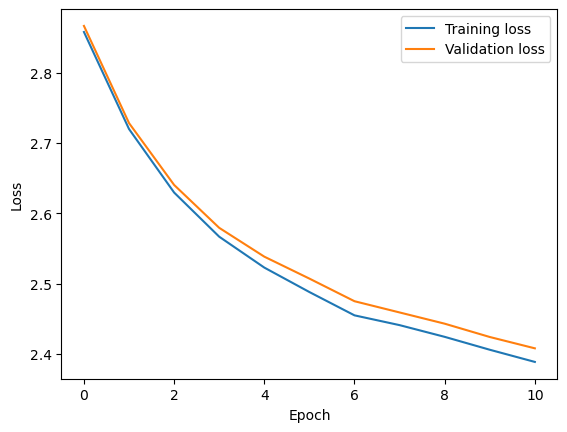

In [7]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

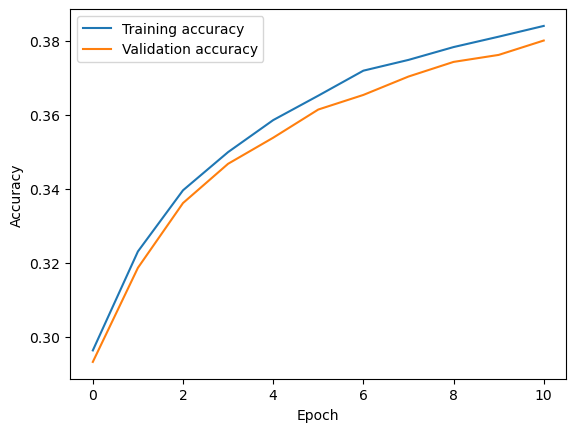

In [11]:
plt.plot(accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [40]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.389
Test accuracy: 0.385


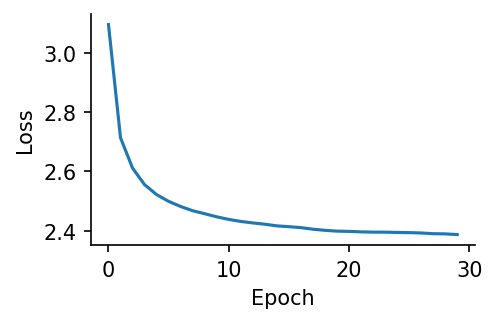

In [43]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [39]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local,_,__ in sparse_data_generator(x_data, y_data, x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense(), batch_size)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [44]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.394
Test accuracy: 0.388


In [45]:
type(w1)

torch.Tensor

In [47]:
torch.save(w1, '/userhome/cs2/u3556571/secondtry/result1/w1.pt')

In [48]:
torch.save(w2, '/userhome/cs2/u3556571/secondtry/result1/w2.pt')